# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

In [869]:
# IMPORTS

import pandas
import pandas as pd
import numpy as np
import re
from typing import Union
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from typing import Callable

random_seed = 11

%matplotlib inline

In [870]:
# HELPERS

def get_frequency_counts(df: pd.DataFrame, column: str) -> dict:
    frequency_count = {}

    for ticket_id in df[column]:
        if ticket_id not in frequency_count:
            frequency_count[ticket_id] = 0

        frequency_count[ticket_id] += 1

    return frequency_count

# used for normalization
scaler = MinMaxScaler()


In [871]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


Process columns

As we can see above, a lot of values are missing and data are dirty, we need to process them.

* pclass - ordinal value, all non null, no change needed
* name - it doesn't seem useful to predict which name will survive and which not, we'll drop this value. We can extract title, more below
* sex - nominal value, we'll apply one-hot encoding
* age - missing values, obviously a very useful metric, we'll predict missing values at the end
* sibsp - no change needed
* parch - no change needed
* ticket - we can extract useful information, more below
* fare - One value is missing. We'll need to fill it, more below
* cabin - a lot of values are missing, but there are still some values that are useful, more below
* embarked - nominal value, some values missing, more below
* home.dest - a lot of values are missing. The data is very dirty, often there's only 1 value, where we don't know what's home and what's dest, we'll
remove it

Processing Name

It doesn't seem useful to predict which name will survive and which not, we'll drop this value. However, a name also contains a title of that person, which
can tell us useful things like marital status.

In [872]:
def find_title(name: str):
    titles = re.findall(r"[A-Z]\S+\.", name)
    if titles:
        return titles[0]
    return "Other"


df["name"].apply(find_title).value_counts()


Mr.          566
Miss.        210
Mrs.         155
Master.       45
Dr.            7
Rev.           4
Col.           4
Mlle.          2
Sir.           1
Capt.          1
Dona.          1
Ms.            1
Countess.      1
Mme.           1
Major.         1
Name: name, dtype: int64

As we can see, there are only 4 common titles, which tell us the marital status of the person. We'll definitely want those

Some titles mean the same thing, but are in different language, like Mlle. -> Miss., so we'll translate those.

Capt. seems also as an interesting title, as captains leave the boat as the latest, however we only have 1, and it's a passenger that paid a fare,
it shouldn't decrease their survival likelihood.

The full function is below

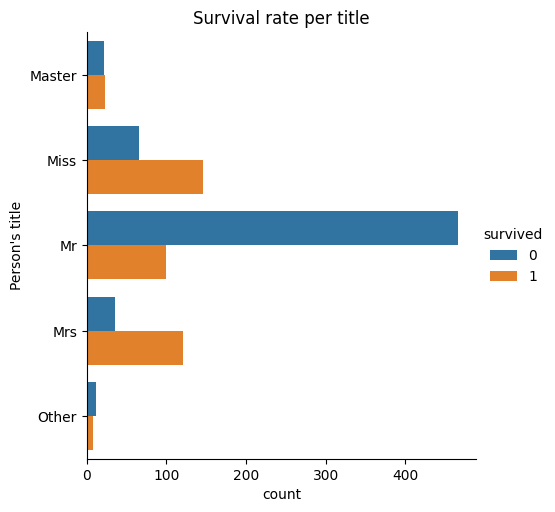

In [873]:
df = pd.read_csv('data.csv')

def get_title(name: str):
    translate_title = {
        "Mlle.": "Miss.",
        "Dona.": "Mrs.",
        "Mme.": "Mrs."
    }

    useful_titles = {"Mr.", "Miss.", "Mrs.", "Master.", "Mlle.", "Dona.", "Mme."}

    title = ""
    for useful_title in useful_titles:
        if useful_title in name:
            title = useful_title

    if title:
        if title in translate_title:
            title = translate_title[title]
        return title[:-1]
    return "Other"

df["title"] = df["name"].apply(get_title)
df.drop("name", axis=1)

graph = sns.catplot(y="title", hue="survived", data=df.sort_values(by='title'), kind="count");
graph.set(ylabel="Person's title", title="Survival rate per title");


Ticket

They’re usually unique numbers, we wouldn’t get much value out of it. However, there seems to be 2 types of tickets, one is that starts with a number and second one starts with a letter. There may be some value hidden there, we’ll split ticket into ones that start with a number and ones that start with a letter.



Yes    734
No     266
Name: ticket_starts_with_letter, dtype: int64


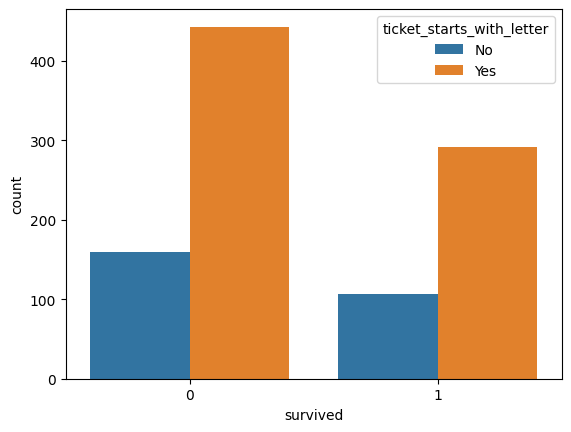

In [874]:
def categorize_ticket(ticket: Union[str, float]) -> str:
    if ticket == np.nan:  # protection in case future data have null
        return "No"
    ticket = ticket.strip()
    if ticket[0].isdigit():
        return "Yes"
    return "No"

df["ticket_starts_with_letter"] = df["ticket"].apply(categorize_ticket)
print(df["ticket_starts_with_letter"].value_counts())
sns.countplot(x='survived', hue ='ticket_starts_with_letter', data=df);


Based on the graph above, the letter of a ticket doesn't seem to be important, however, we can see that some people have the same ticket multiple times.
We can see if that value could have any impact

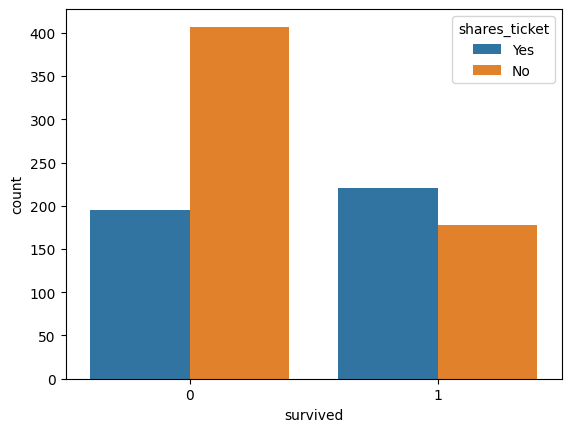

In [875]:
def find_if_duplicate_ticket(df: pandas.DataFrame):
    frequency_count = get_frequency_counts(df, "ticket")

    df["shares_ticket"] = df["ticket"].apply(lambda x: "Yes" if frequency_count[x] > 1 else "No")
    return df

df = find_if_duplicate_ticket(df)
df["shares_ticket"].value_counts()
df.drop("ticket", axis=1)

sns.countplot(x='survived', hue ='shares_ticket', data=df);

Based on the graph, it looks like people, who shared ticket were more likely to survive. We'll use this value from tickets, and not if they start with
a letter.

Fare
one value is missing. I’ve also seen instances when fare was 0. I won’t be changing this value and assuming that it was for free. There are no negative numbers, but if they were, I’m assuming that a passenger got paid.


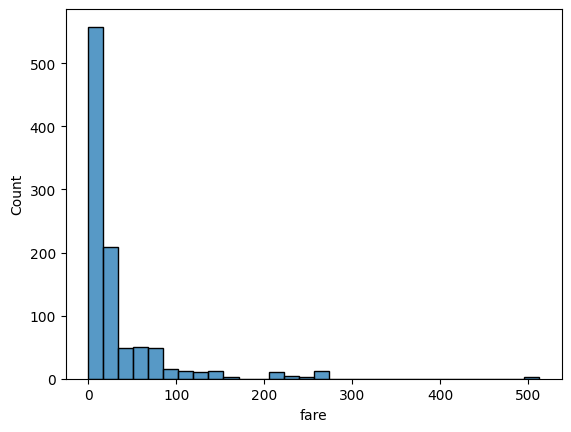

In [876]:
sns.histplot(df['fare'], bins=30, kde=False);

Fare prices seem to be skewed, that's why we'll use median to fill the missing values

In [877]:
df['fare'] = df['fare'].fillna(df['fare'].median())

Cabin

Most values are missing, that's why it's not reasonable to work with the text. Instead, if Cabin is not nan, we can take it as a person was in the cabin, otherwise they weren't.


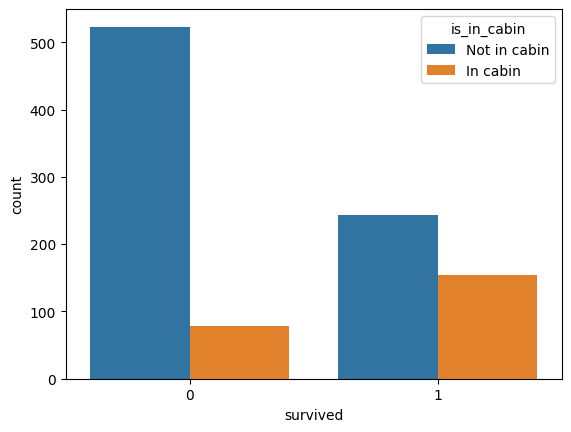

In [878]:
df["is_in_cabin"] = df["cabin"].apply(lambda x: "In cabin" if type(x) == str else "Not in cabin")
sns.countplot(x='survived', hue='is_in_cabin', data=df);


It seems like people in cabin are more likely to survive, we'll be including this value

Embarked

We have 2 missing values. As a person must've embarked from somewhere, since they're on the boat, we can conclude that these values are missing and
not intentionally nan.

We'll replace the data with the most used one.

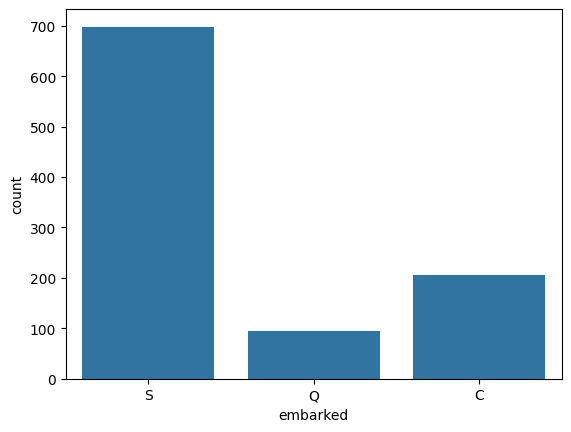

In [879]:
sns.countplot(x='embarked', data=df);

In [880]:
frequency_counts = get_frequency_counts(df, "embarked")
most_freq_embarked = max(frequency_counts, key=frequency_counts.get)
df["embarked"] = df["embarked"].apply(lambda x: most_freq_embarked if x == np.nan else x)

Now let's combine all of the data processing above into a function.

Since all of the data that are object are nominal now, we can apply one-hot encoding at the end to get the dummy values.

We'll fill age after processing of the data, since we need this data in order to predict the age.

In [881]:

def process_data(df: pandas.DataFrame) -> pandas.DataFrame:
    df.set_index("ID", inplace=True)

    df["title"] = df["name"].apply(get_title)
    df = df.drop("name", axis=1)

    df = find_if_duplicate_ticket(df)
    df = df.drop("ticket", axis=1)

    df['fare'] = df['fare'].fillna(df['fare'].median())

    df["is_in_cabin"] = df["cabin"].apply(lambda x: "In cabin" if type(x) == str else "Not in cabin")
    df = df.drop("cabin", axis=1)

    frequency_counts = get_frequency_counts(df, "embarked")
    most_freq_embarked = max(frequency_counts, key=frequency_counts.get)
    df["embarked"] = df["embarked"].apply(lambda x: most_freq_embarked if x == np.nan else x)

    df = df.drop("home.dest", axis=1)

    # get dummies out of all nominal values
    df = pd.get_dummies(df)

    return df

df = pd.read_csv('data.csv')
df = process_data(df)

df
# df["title"].value_counts()


,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,shares_ticket_No,shares_ticket_Yes,is_in_cabin_In cabin,is_in_cabin_Not in cabin
ID,,,,,,,,,,,,,,,,,,,,
0,0,3,11.0,5,2,46.9000,0,1,0,0,1,1,0,0,0,0,0,1,0,1
1,0,3,NaN,0,0,7.0500,0,1,0,0,1,0,0,1,0,0,1,0,0,1
2,0,3,4.0,3,2,27.9000,0,1,0,0,1,1,0,0,0,0,0,1,0,1
3,1,3,NaN,1,0,15.5000,1,0,0,1,0,0,0,0,1,0,0,1,0,1
4,1,3,18.0,0,0,7.2292,1,0,1,0,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,52.0,0,0,13.0000,0,1,0,0,1,0,0,1,0,0,0,1,0,1
996,0,2,29.0,0,0,10.5000,0,1,0,0,1,0,0,1,0,0,1,0,0,1
997,0,1,56.0,0,0,26.5500,0,1,0,0,1,0,0,1,0,0,1,0,0,1


Predict age

I've tried to play around with DecisionTreeRegressor, however

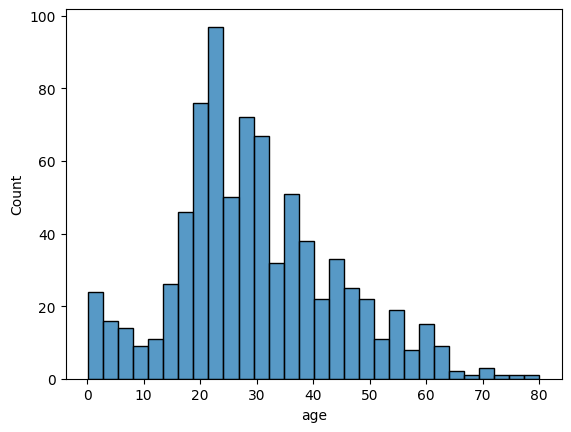

In [882]:
sns.histplot(df['age'], bins=30, kde=False);

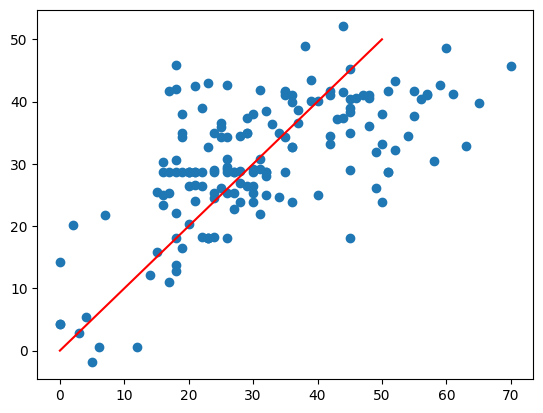

Squared error of predict age: 11.152827997891094


In [883]:
from sklearn.tree import DecisionTreeRegressor


def get_trained_model(df: pd.DataFrame) -> (DecisionTreeRegressor, list):

    # we don't want to use survived for predicting age, as it's a data that we want to predict in the end
    df_predict_age = df.drop("survived", axis=1)

    # split the data into ones we'll train on and ones we'll predict
    # Using copy() to prevent warnings
    df_with_age = df_predict_age[df['age'].notna()].copy()
    # since we'll want to work with ages as whole numbers, we'll get rid of the decimal places for training
    df_with_age["age"] = df_with_age["age"].astype(int)

    # split the data into X and Y
    Xtrain, Xval, Ytrain, Yval = train_test_split(
        df_with_age.drop('age', axis=1), df_with_age.age, test_size=0.2, random_state=random_seed
    )

    # normalize the data
    Xtrain = scaler.fit_transform(Xtrain)
    Xval = scaler.fit_transform(Xval)

    # find the most optimal depth
    decision_regressor = LinearRegression()
    # decision_regressor = DecisionTreeRegressor(max_depth=best_depth)
    decision_regressor.fit(Xtrain, Ytrain)

    predicted_ages = decision_regressor.predict(Xval)
    plt.scatter(Yval, predicted_ages)
    plt.plot([0,50], [0,50], 'r')
    plt.show()

    print('Squared error of predict age:', np.sqrt(mean_squared_error(np.array(Yval), predicted_ages)))

    return decision_regressor, predicted_ages


def predict_age(df: pd.DataFrame, trained_model: DecisionTreeRegressor) -> pd.DataFrame:

    df_new = df.drop("survived", axis=1)
    # predict missing values
    df_with_age = df_new[df_new['age'].notna()].copy()
    df_without_age = df_new[df_new['age'].isna()].copy()

    Xpredict = df_without_age.drop("age", axis=1)
    Xpredict = scaler.fit_transform(Xpredict)

    predicted_age = trained_model.predict(Xpredict)
    df_without_age["age"] = predicted_age

    df_to_attach = pd.concat([df_with_age, df_without_age], axis=0).sort_index()
    df["age"] = df_to_attach["age"]

    # get rid of floats, round the age
    df["age"] = df["age"].apply(lambda x: int(round(x)))

    return df, df_without_age


trained_model, predicted_ages = get_trained_model(df)
df, df_predicted_age = predict_age(df, trained_model)


Now we can see that all values of age are filled in based on the Decision tree regression with the depth of 4, has the lowest mean squared error.

28.71875    31
35.96875    20
25.43750    19
28.68750    11
26.46875    11
            ..
30.09375     1
23.43750     1
22.59375     1
25.21875     1
4.46875      1
Name: age, Length: 85, dtype: int64

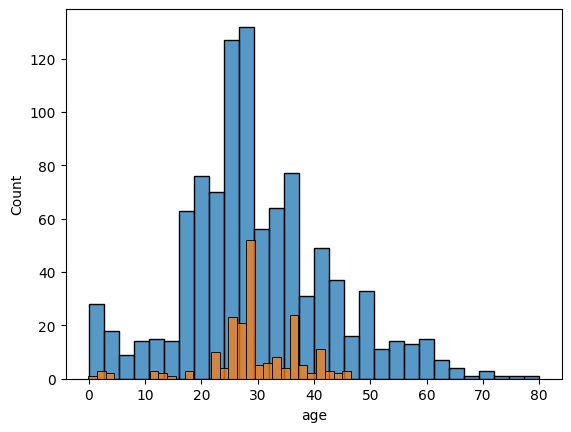

In [884]:
sns.histplot(df['age'], bins=30, kde=False);

sns.histplot(df_predicted_age['age'], bins=30, kde=False);

df_predicted_age['age'].value_counts()

In [885]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   survived                  1000 non-null   int64  
 1   pclass                    1000 non-null   int64  
 2   age                       1000 non-null   int64  
 3   sibsp                     1000 non-null   int64  
 4   parch                     1000 non-null   int64  
 5   fare                      1000 non-null   float64
 6   sex_female                1000 non-null   uint8  
 7   sex_male                  1000 non-null   uint8  
 8   embarked_C                1000 non-null   uint8  
 9   embarked_Q                1000 non-null   uint8  
 10  embarked_S                1000 non-null   uint8  
 11  title_Master              1000 non-null   uint8  
 12  title_Miss                1000 non-null   uint8  
 13  title_Mr                  1000 non-null   uint8  
 14  title_Mrs

Split code into:
Training - to train the model
Testing - to find the error rate / performance of our model
parts, to use them for Decision tree and KNN algorithms

Since we're

In [886]:

# split the data into X and Y
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    df.drop('survived', axis=1), df.survived, test_size=0.2, random_state=random_seed
)

Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)

# normalize the values we're using to predict
# Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)


Decision tree

In [896]:

def cross_validate(parameters, model_class: Callable):
    param_comb = ParameterGrid(parameters)

    val_metric = []
    for params in param_comb:
        print(params)
        clf = model_class(**params)
        # cross validation
        fold_acc = cross_val_score(clf, Xtrain, Ytrain, cv=5)
        val_metric.append(np.mean(fold_acc))

    best_params = param_comb[np.argmax(val_metric)]
    best_score = max(val_metric)

    print(f"Cross validation completed for {str(model_class)}, best hyperparameters: {best_params}, best validation score: {best_score}")

    return best_params, best_score, val_metric

decision_tree_max_depth = 100

param_grid = {
    'max_depth': range(1, decision_tree_max_depth),
    'criterion': ['gini', 'entropy', 'log_loss']
}

best_tree_params, best_tree_score, all_metrics = cross_validate(param_grid, DecisionTreeClassifier)

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'gini', 'max_depth': 3}
{'criterion': 'gini', 'max_depth': 4}
{'criterion': 'gini', 'max_depth': 5}
{'criterion': 'gini', 'max_depth': 6}
{'criterion': 'gini', 'max_depth': 7}
{'criterion': 'gini', 'max_depth': 8}
{'criterion': 'gini', 'max_depth': 9}
{'criterion': 'gini', 'max_depth': 10}
{'criterion': 'gini', 'max_depth': 11}
{'criterion': 'gini', 'max_depth': 12}
{'criterion': 'gini', 'max_depth': 13}
{'criterion': 'gini', 'max_depth': 14}
{'criterion': 'gini', 'max_depth': 15}
{'criterion': 'gini', 'max_depth': 16}
{'criterion': 'gini', 'max_depth': 17}
{'criterion': 'gini', 'max_depth': 18}
{'criterion': 'gini', 'max_depth': 19}
{'criterion': 'gini', 'max_depth': 20}
{'criterion': 'gini', 'max_depth': 21}
{'criterion': 'gini', 'max_depth': 22}
{'criterion': 'gini', 'max_depth': 23}
{'criterion': 'gini', 'max_depth': 24}
{'criterion': 'gini', 'max_depth': 25}
{'criterion': 'gini', 'max_depth':

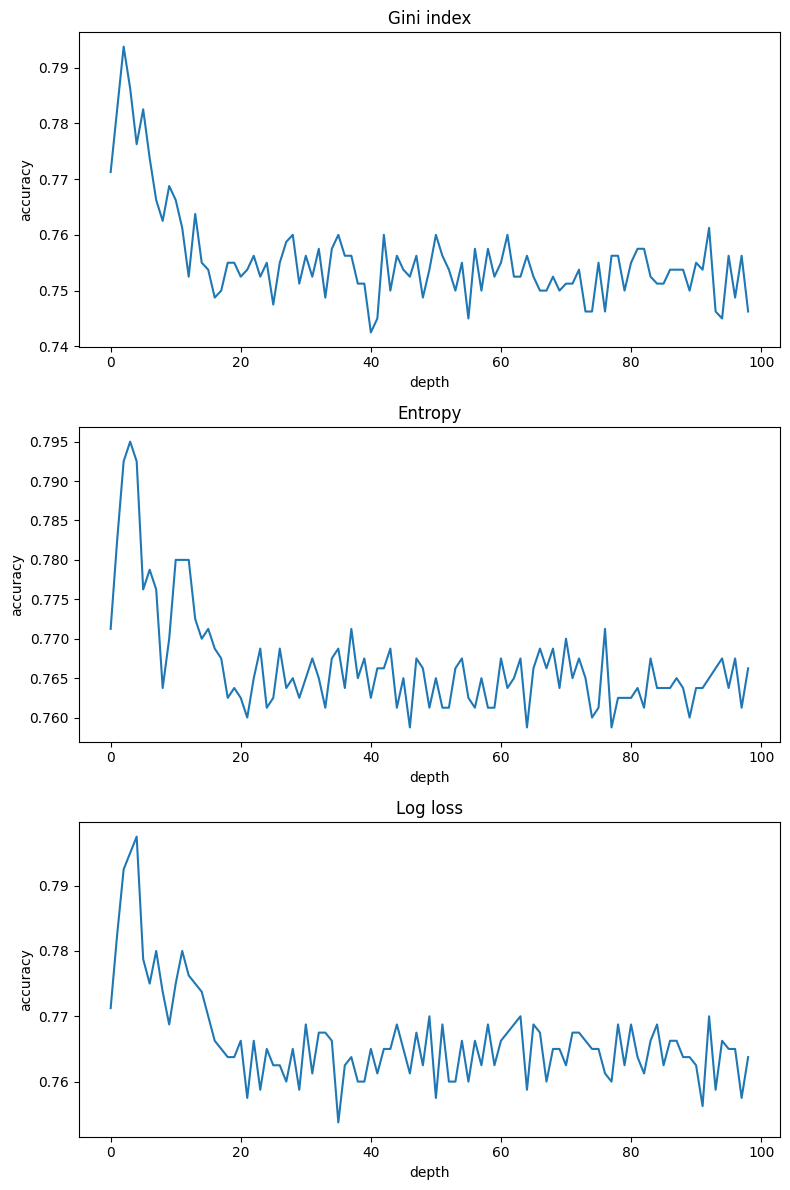

In [892]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

ax[0].plot(all_metrics[:decision_tree_max_depth-1])
ax[0].set_title('Gini index')
ax[0].set_xlabel('depth')
ax[0].set_ylabel('accuracy')

ax[1].plot(all_metrics[decision_tree_max_depth-1:decision_tree_max_depth*2-2])
ax[1].set_title('Entropy')
ax[1].set_xlabel('depth')
ax[1].set_ylabel('accuracy')

ax[2].plot(all_metrics[decision_tree_max_depth*2-2:])
ax[2].set_title('Log loss')
ax[2].set_xlabel('depth')
ax[2].set_ylabel('accuracy')

plt.tight_layout()

In [889]:
best_decision_tree_model = DecisionTreeClassifier(**best_tree_params)
best_decision_tree_model.fit(Xtrain, Ytrain)

feature_importances = best_decision_tree_model.feature_importances_

# Display feature importances
for feature, importance in zip(Xtrain.columns, feature_importances):
    print(f'{feature}: {importance}')

pclass: 0.19608600902138137
age: 0.07428438540207166
sibsp: 0.01228048777684056
parch: 0.009215896296446755
fare: 0.16097493841625982
sex_female: 0.009767468149146615
sex_male: 0.0
embarked_C: 0.0
embarked_Q: 0.0
embarked_S: 0.0
title_Master: 0.0
title_Miss: 0.0
title_Mr: 0.47143954773994556
title_Mrs: 0.0
title_Other: 0.04064697430213787
shares_ticket_No: 0.0
shares_ticket_Yes: 0.01451400300630387
is_in_cabin_In cabin: 0.0
is_in_cabin_Not in cabin: 0.010790289889465884


Analysis of the effectivity of Decision tree model on the test data

/Library/Python/3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


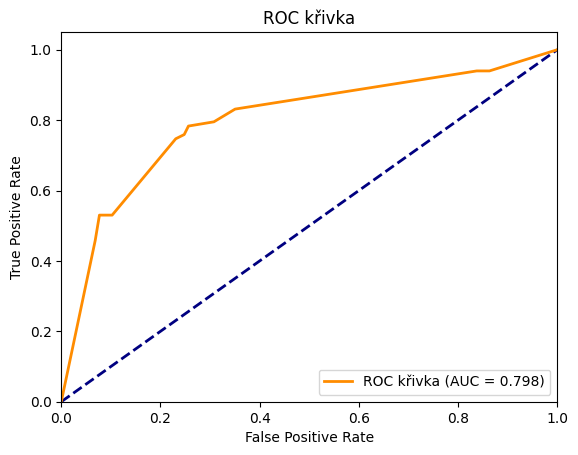

In [890]:
Yprobability = best_decision_tree_model.predict_proba(Xtest)
p1_hat = Yprobability[:,1]

fpr, tpr, thresholds = roc_curve(Ytest, p1_hat)

AUC = roc_auc_score(Ytest, p1_hat)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()


In [891]:
Ypredicted = best_decision_tree_model.predict(Xtest)

print(f'Accuracy score (test): {accuracy_score(Ytest, Ypredicted):.4f}')
print(f'F1 score (test): {f1_score(Ytest, Ypredicted):.4f}')

Accuracy score (test): 0.7600
F1 score (test): 0.7209


/Library/Python/3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


KNN neighbors

In [897]:
knn_max_neighbors = 50

param_grid = {
    'n_neighbors': range(1, knn_max_neighbors),
    'weights': ['uniform', 'distance'],
    "p": [1, 2]
}

best_knn_params, best_knn_score, all_metrics = cross_validate(param_grid, KNeighborsClassifier)

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
{'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
{'n_neighb

[0.7425,
 0.7425,
 0.74125,
 0.74125,
 0.7787499999999999,
 0.7424999999999999,
 0.7749999999999999,
 0.74125,
 0.7875,
 0.7612500000000001,
 0.7825,
 0.765,
 0.7775,
 0.76875,
 0.76875,
 0.76625,
 0.7950000000000002,
 0.76,
 0.7949999999999999,
 0.765,
 0.7775000000000001,
 0.7699999999999999,
 0.78125,
 0.7737499999999999,
 0.7950000000000002,
 0.7662500000000001,
 0.7975,
 0.77375,
 0.7924999999999999,
 0.7725000000000001,
 0.7925,
 0.77375,
 0.79125,
 0.7737499999999999,
 0.79125,
 0.7787499999999999,
 0.79375,
 0.775,
 0.7925000000000001,
 0.7825,
 0.8087499999999999,
 0.7725,
 0.7975,
 0.775,
 0.7987499999999998,
 0.7775000000000001,
 0.79375,
 0.78125,
 0.8012499999999999,
 0.7775000000000001,
 0.7925,
 0.7762499999999999,
 0.78625,
 0.7825,
 0.78875,
 0.78,
 0.7949999999999999,
 0.77875,
 0.7949999999999999,
 0.7775,
 0.7837500000000001,
 0.7787499999999999,
 0.79,
 0.7762499999999999,
 0.8025,
 0.78,
 0.7987500000000001,
 0.7825,
 0.7874999999999999,
 0.78,
 0.7849999999999999

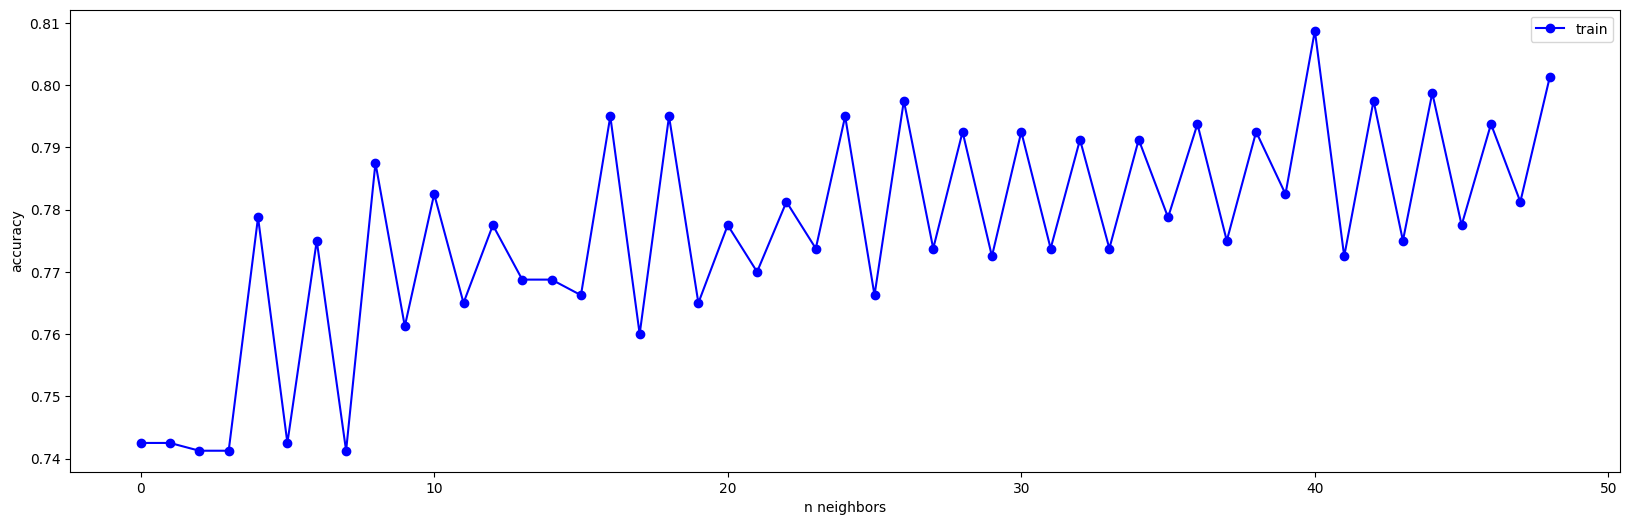

In [895]:
plt.figure(figsize=(20,6))
plt.plot(all_metrics[:knn_max_neighbors-1], 'ob-')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

all_metrics